In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install mxnet-cu101
!pip install gluonnlp pandas tqdm
!pip install sentencepiece==0.1.85
!pip install transformers==2.1.1
!pip install torch==1.3.1

     |████████████████████████████████| 710.5MB 26kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 256kB 2.8MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.9.1-cp36-cp36m-linux_x86_64.whl size=470035 sha256=b67b9c4f08c8a16207b6013824eb5a064b75cf51be748b4c9edc2092c47e3412
  Stored in directory: /root/.cache/pip/wheels/af/60/16/1f8a40e68b85bd9bd7960e91830bca5e40cd113f3220b7e231
Successfully built gluonnlp
     |████████████████████████████████| 1.0MB 2.8MB/s 
     |████████████████████████████████| 317kB 2.8MB/s 
     |████████████████████████████████| 890kB 8.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=a9abd844f041193d38a1c179a403ebadf68f357b05e26de3e05efaa25a5e8b57
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremos

In [3]:
import argparse
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import json
import pandas as pd
from pathlib import Path
from torch.utils.data import Dataset,DataLoader
from transformers import GPT2Config
from gluonnlp.data import SentencepieceTokenizer
from typing import Tuple, List, Callable

import os
os.chdir('/content/drive/My Drive/GPT/07_02_gpt/') # change to your directory
from kogpt2.utils import get_tokenizer
from kogpt2.pytorch_kogpt2 import get_pytorch_kogpt2_model

import os
os.chdir('/content/drive/My Drive/GPT/07_02_gpt/BERT_pairwise_text_classification/') # change to your directory
from model.net import PairwiseClassifier
from model.data import Corpus
from model.utils import PreProcessor, PadSequence
from model.metric import evaluate, acc
from utils import Config, CheckpointManager, SummaryManager
from tqdm import tqdm, tqdm_notebook
from torch.utils.tensorboard import SummaryWriter

In [4]:
epochs = 20
batch_size = 64
learning_rate = 5e-5
weight_decay = 5e-4

In [20]:
device = torch.device("cuda")
print(device)
gpt2model, vocab = get_pytorch_kogpt2_model()

cuda
using cached model
using cached model


In [6]:
class Corpus(Dataset):
    """Corpus class"""
    def __init__(self, filepath: str, transform_fn: Callable[[str], List[int]]) -> None:
        """Instantiating Corpus class
        Args:
            filepath (str): filepath
            transform_fn (Callable): a function that can act as a transformer
        """
        self._corpus = pd.read_csv(filepath, sep='\t')
        self._transform = transform_fn

    def __len__(self) -> int:
        return len(self._corpus)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        q1, q2, is_duplicate = self._corpus.iloc[idx].tolist()
        list_of_indices, list_of_token_types = [torch.tensor(elm) for elm in self._transform(q1, q2)]
        label = torch.tensor(is_duplicate)
        return list_of_indices, list_of_token_types, label

In [7]:
def get_preprocessor(ptr_config_info):
    with open(ptr_config_info.vocab, mode='rb') as io:
        vocab = pickle.load(io)
        
        ptr_tokenizer = SentencepieceTokenizer(ptr_config_info.tokenizer)
        pad_sequence = PadSequence(length=64, pad_val=vocab.to_indices(vocab.padding_token))
        preprocessor = PreProcessor(vocab=vocab, split_fn=ptr_tokenizer, pad_fn=pad_sequence)
    
    return preprocessor

def get_data_loaders(dataset_config, preprocessor, batch_size):
    tr_ds = Corpus(dataset_config["train"], preprocessor.preprocess)
    tr_dl = DataLoader(tr_ds, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
    val_ds = Corpus(dataset_config["validation"], preprocessor.preprocess)
    val_dl = DataLoader(val_ds, batch_size=batch_size, num_workers=4)
    return tr_dl, val_dl

class PairwiseClassifier(nn.Module):
    def __init__(self, 
                 gpt2,
                 num_classes, 
                 vocab, 
                 hidden_size=768, 
                 dr_rate = None):# -> None:
        super(PairwiseClassifier, self).__init__()
        self.gpt2 = gpt2model
        self.classifier = nn.Linear(hidden_size, num_classes)
        self.vocab = vocab
        self.dr_rate = dr_rate
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)

    def forward(self, input_ids, token_type_ids) -> torch.Tensor:
        _, pooled_output = self.gpt2(input_ids = input_ids, token_type_ids=token_type_ids.long())
        pool = pooled_output[:,-1]
        
        if self.dr_rate:
            out = self.dropout(pool)
        return self.classifier(out)

train_l = []
train_a = []
val_l = []
val_a = []

def main():
    dataset_config = {
    "train": "qpair/train.txt",
    "validation": "qpair/validation.txt",
    "test": "qpair/test.txt"
    }

    ptr_config_info = Config(f"conf/pretrained/skt.json")
    preprocessor = get_preprocessor(ptr_config_info)

    with open(ptr_config_info.config, mode="r") as io:
        ptr_config = json.load(io)
  
    config = GPT2Config()
    
    model = PairwiseClassifier(gpt2model, num_classes=2, vocab=vocab, dr_rate=0.5)    
    tr_dl, val_dl = get_data_loaders(dataset_config, preprocessor, batch_size)
    
    loss_fn = nn.CrossEntropyLoss()
    
    from transformers import AdamW
    optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    #optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)
    
    print('Transfer Learning Start')
    for epoch in range(epochs):

        train_acc = 0.0
        val_acc = 0.0
        model.train()
        for step, mb in enumerate(tqdm_notebook(tr_dl)):
            x_mb, x_types_mb, label = map(lambda elm: elm.to(device), mb)
            optimizer.zero_grad()
            out = model(x_mb, x_types_mb)
            loss = loss_fn(out, label)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer.step()
            train_acc += acc(out, label)

            train_l.append(loss.data.cpu().numpy())
            train_a.append(train_acc / (step + 1))

            if step % 20 == 0:
                print("epoch {} batch id {} loss {} train acc {}".format(epoch+1, step+1, loss.data.cpu().numpy(), train_acc / (step+1)))

        print("epoch {} train acc {}".format(epoch+1, train_acc / (step+1)))
        with open('checkpoint2/checkpoint_{}.model'.format(str(epoch + 1).zfill(2)), 'wb') as f:
            torch.save(model.state_dict(), f)
        
        model.eval()    
        for step, mb in tqdm(enumerate(val_dl)):
            x_mb, x_types_mb, label = map(lambda elm: elm.to(device), mb)
            out = model(x_mb, x_types_mb)
            val_acc += acc(out, label)
            val_a.append(val_acc / (step + 1))
        print("epoch {} val acc {}".format(epoch+1, val_acc / (step+1)))               

In [8]:
if __name__ == '__main__':
    main()

Transfer Learning Start


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:82: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


epoch 1 batch id 1 loss 0.8019208312034607 train acc 0.390625
epoch 1 batch id 21 loss 0.6933029890060425 train acc 0.412202388048172
epoch 1 batch id 41 loss 0.6269749999046326 train acc 0.5003810524940491
epoch 1 batch id 61 loss 0.6492792367935181 train acc 0.5591700673103333
epoch 1 batch id 81 loss 0.6509382128715515 train acc 0.5854552388191223

epoch 1 train acc 0.5986842513084412


11it [00:02,  5.49it/s]

epoch 1 val acc 0.630005419254303


epoch 2 batch id 1 loss 0.5987437963485718 train acc 0.71875
epoch 2 batch id 21 loss 0.7062364220619202 train acc 0.6808035969734192
epoch 2 batch id 41 loss 0.5843883752822876 train acc 0.6814023852348328
epoch 2 batch id 61 loss 0.6078805923461914 train acc 0.680327832698822
epoch 2 batch id 81 loss 0.617685079574585 train acc 0.6815200448036194

epoch 2 train acc 0.6802631616592407


11it [00:01,  5.70it/s]


epoch 2 val acc 0.630005419254303


epoch 3 batch id 1 loss 0.6703267097473145 train acc 0.640625
epoch 3 batch id 21 loss 0.6022749543190002 train acc 0.6778274178504944
epoch 3 batch id 41 loss 0.5867375731468201 train acc 0.6787347197532654
epoch 3 batch id 61 loss 0.6421294808387756 train acc 0.6775102019309998
epoch 3 batch id 81 loss 0.5640642046928406 train acc 0.6770833134651184

epoch 3 train acc 0.678947389125824


11it [00:01,  5.76it/s]

epoch 3 val acc 0.630005419254303


epoch 4 batch id 1 loss 0.6879810094833374 train acc 0.59375
epoch 4 batch id 21 loss 0.5980845093727112 train acc 0.6941964626312256
epoch 4 batch id 41 loss 0.5951471924781799 train acc 0.6920731663703918
epoch 4 batch id 61 loss 0.6267849802970886 train acc 0.6923667788505554
epoch 4 batch id 81 loss 0.5612421035766602 train acc 0.7023534178733826

epoch 4 train acc 0.7041118741035461


11it [00:01,  5.74it/s]

epoch 4 val acc 0.6855384707450867


epoch 5 batch id 1 loss 0.6297792196273804 train acc 0.671875
epoch 5 batch id 21 loss 0.42195945978164673 train acc 0.746279776096344
epoch 5 batch id 41 loss 0.5491853356361389 train acc 0.7419969439506531
epoch 5 batch id 61 loss 0.6383086442947388 train acc 0.7430839538574219
epoch 5 batch id 81 loss 0.5087470412254333 train acc 0.7496141791343689

epoch 5 train acc 0.7481908202171326


11it [00:01,  5.70it/s]

epoch 5 val acc 0.7247024178504944


epoch 6 batch id 1 loss 0.5163723230361938 train acc 0.765625
epoch 6 batch id 21 loss 0.6709814667701721 train acc 0.7805059552192688
epoch 6 batch id 41 loss 0.4881683588027954 train acc 0.7717225551605225
epoch 6 batch id 61 loss 0.4858468770980835 train acc 0.7692109942436218
epoch 6 batch id 81 loss 0.5304127335548401 train acc 0.7644675970077515

epoch 6 train acc 0.761019766330719


11it [00:01,  5.74it/s]

epoch 6 val acc 0.7360660433769226


epoch 7 batch id 1 loss 0.4935910105705261 train acc 0.828125
epoch 7 batch id 21 loss 0.45662832260131836 train acc 0.793154776096344
epoch 7 batch id 41 loss 0.5466466546058655 train acc 0.7831554412841797
epoch 7 batch id 61 loss 0.5441599488258362 train acc 0.7799692153930664
epoch 7 batch id 81 loss 0.44105347990989685 train acc 0.7804784178733826

epoch 7 train acc 0.7810855507850647


11it [00:01,  5.95it/s]

epoch 7 val acc 0.7552760243415833


epoch 8 batch id 1 loss 0.45906123518943787 train acc 0.734375
epoch 8 batch id 21 loss 0.4694618880748749 train acc 0.7946428656578064
epoch 8 batch id 41 loss 0.36853957176208496 train acc 0.7934451103210449
epoch 8 batch id 61 loss 0.4751003086566925 train acc 0.8040471076965332
epoch 8 batch id 81 loss 0.4489811360836029 train acc 0.8051697611808777

epoch 8 train acc 0.8064144849777222


11it [00:01,  5.62it/s]


epoch 8 val acc 0.7565611004829407


epoch 9 batch id 1 loss 0.3119881749153137 train acc 0.859375
epoch 9 batch id 21 loss 0.42961618304252625 train acc 0.8191964626312256
epoch 9 batch id 41 loss 0.4999074339866638 train acc 0.8197408318519592
epoch 9 batch id 61 loss 0.3557825982570648 train acc 0.8191598057746887
epoch 9 batch id 81 loss 0.25917601585388184 train acc 0.8227237462997437

epoch 9 train acc 0.8223684430122375


11it [00:01,  5.94it/s]

epoch 9 val acc 0.7687365412712097


epoch 10 batch id 1 loss 0.30204054713249207 train acc 0.890625
epoch 10 batch id 21 loss 0.38948532938957214 train acc 0.8452380895614624
epoch 10 batch id 41 loss 0.4106608033180237 train acc 0.8418444991111755
epoch 10 batch id 61 loss 0.45881322026252747 train acc 0.8404200077056885
epoch 10 batch id 81 loss 0.37085041403770447 train acc 0.8429784178733826

epoch 10 train acc 0.8439145088195801


11it [00:01,  5.77it/s]


epoch 10 val acc 0.775162398815155


epoch 11 batch id 1 loss 0.5025309324264526 train acc 0.78125
epoch 11 batch id 21 loss 0.40080952644348145 train acc 0.8288690447807312
epoch 11 batch id 41 loss 0.24973127245903015 train acc 0.8395578861236572
epoch 11 batch id 61 loss 0.3369014859199524 train acc 0.8396515846252441
epoch 11 batch id 81 loss 0.42569050192832947 train acc 0.8431712985038757

epoch 11 train acc 0.847039520740509


11it [00:01,  5.70it/s]

epoch 11 val acc 0.8129058480262756


epoch 12 batch id 1 loss 0.3774840235710144 train acc 0.828125
epoch 12 batch id 21 loss 0.2891835868358612 train acc 0.8735119104385376
epoch 12 batch id 41 loss 0.264573872089386 train acc 0.8742377758026123
epoch 12 batch id 61 loss 0.2828223705291748 train acc 0.867827832698822
epoch 12 batch id 81 loss 0.4116405248641968 train acc 0.8701774477958679

epoch 12 train acc 0.86726975440979


11it [00:01,  5.63it/s]

epoch 12 val acc 0.8242694735527039


epoch 13 batch id 1 loss 0.24600453674793243 train acc 0.9375
epoch 13 batch id 21 loss 0.22196301817893982 train acc 0.8809524178504944
epoch 13 batch id 41 loss 0.26234278082847595 train acc 0.8772865533828735
epoch 13 batch id 61 loss 0.3469027876853943 train acc 0.876280665397644
epoch 13 batch id 81 loss 0.3280300498008728 train acc 0.875

epoch 13 train acc 0.8717105388641357


11it [00:01,  5.87it/s]

epoch 13 val acc 0.8277868032455444


epoch 14 batch id 1 loss 0.22718721628189087 train acc 0.9375
epoch 14 batch id 21 loss 0.23914405703544617 train acc 0.8876488208770752
epoch 14 batch id 41 loss 0.23841063678264618 train acc 0.8803353309631348
epoch 14 batch id 61 loss 0.32451722025871277 train acc 0.8767929673194885
epoch 14 batch id 81 loss 0.2864477336406708 train acc 0.8777006268501282

epoch 14 train acc 0.8784539699554443


11it [00:01,  5.81it/s]

epoch 14 val acc 0.8406385183334351


epoch 15 batch id 1 loss 0.2831782102584839 train acc 0.890625
epoch 15 batch id 21 loss 0.22718682885169983 train acc 0.8936011791229248
epoch 15 batch id 41 loss 0.32422593235969543 train acc 0.8932926654815674
epoch 15 batch id 61 loss 0.31971731781959534 train acc 0.892930269241333
epoch 15 batch id 81 loss 0.2985857129096985 train acc 0.8917824029922485

epoch 15 train acc 0.8927631974220276


11it [00:01,  5.73it/s]


epoch 15 val acc 0.8413825631141663


epoch 16 batch id 1 loss 0.28113630414009094 train acc 0.921875
epoch 16 batch id 21 loss 0.1853938102722168 train acc 0.8980655074119568
epoch 16 batch id 41 loss 0.25614240765571594 train acc 0.903201162815094
epoch 16 batch id 61 loss 0.23869147896766663 train acc 0.9082991480827332
epoch 16 batch id 81 loss 0.3234306573867798 train acc 0.9052854776382446

epoch 16 train acc 0.9064145088195801


11it [00:01,  5.77it/s]

epoch 16 val acc 0.8435470461845398


epoch 17 batch id 1 loss 0.3068937361240387 train acc 0.859375
epoch 17 batch id 21 loss 0.16120871901512146 train acc 0.9114583730697632
epoch 17 batch id 41 loss 0.18088530004024506 train acc 0.9089176654815674
epoch 17 batch id 61 loss 0.26767608523368835 train acc 0.9070183634757996
epoch 17 batch id 81 loss 0.30426281690597534 train acc 0.9056712985038757

epoch 17 train acc 0.9057565927505493


11it [00:01,  5.96it/s]

epoch 17 val acc 0.841314971446991


epoch 18 batch id 1 loss 0.18299394845962524 train acc 0.9375
epoch 18 batch id 21 loss 0.2167133092880249 train acc 0.9166666865348816
epoch 18 batch id 41 loss 0.3764711618423462 train acc 0.9024389982223511
epoch 18 batch id 61 loss 0.19164219498634338 train acc 0.9067622423171997
epoch 18 batch id 81 loss 0.23576438426971436 train acc 0.9089506268501282

epoch 18 train acc 0.9077302813529968


11it [00:01,  5.82it/s]

epoch 18 val acc 0.8484848737716675


epoch 19 batch id 1 loss 0.22271177172660828 train acc 0.921875
epoch 19 batch id 21 loss 0.3986523449420929 train acc 0.9174107313156128
epoch 19 batch id 41 loss 0.2040657103061676 train acc 0.9165396094322205
epoch 19 batch id 61 loss 0.10845349729061127 train acc 0.9162396788597107
epoch 19 batch id 81 loss 0.1384964883327484 train acc 0.9195601940155029

epoch 19 train acc 0.9185855388641357


11it [00:01,  5.92it/s]

epoch 19 val acc 0.867018461227417


epoch 20 batch id 1 loss 0.2878594994544983 train acc 0.890625
epoch 20 batch id 21 loss 0.10705617070198059 train acc 0.9255952835083008
epoch 20 batch id 41 loss 0.2094832956790924 train acc 0.9249237179756165
epoch 20 batch id 61 loss 0.11217324435710907 train acc 0.9290471076965332
epoch 20 batch id 81 loss 0.19883564114570618 train acc 0.9270833134651184

epoch 20 train acc 0.9258224368095398


11it [00:01,  5.59it/s]

epoch 20 val acc 0.8392180800437927


In [12]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
    plt.plot(history)
    plt.ylabel(string)
    plt.xlabel('epoch')
    plt.legend([string, 'epoch'])
    plt.title('PARAPHRASING FINE-TUNING {0}'.format(string.upper()))
    plt.savefig('{0}_loss2.jpg'.format(string))
    plt.show()

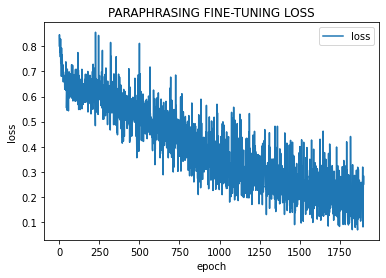

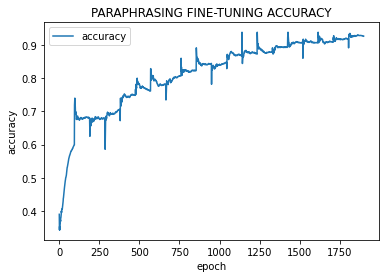

1900 1900


In [13]:
plot_graphs(train_l, 'loss')
plot_graphs(train_a, 'accuracy')

print(len(train_l),len(train_a))

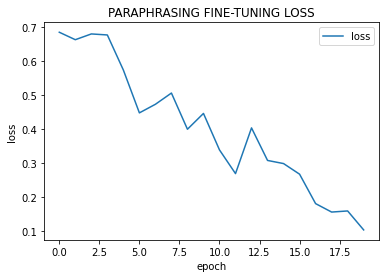

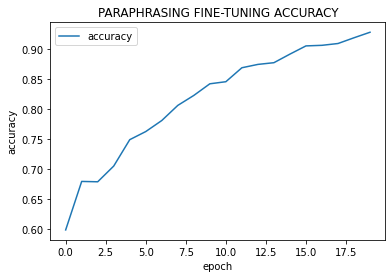

In [14]:
l = []
a = []
for i in range(1, 21):
  l.append(train_l[94*i])
  a.append(train_a[94*i])

plot_graphs(l, 'loss')
plot_graphs(a, 'accuracy')